### Water Quality Prediction - Principle of Component Analyisis.

In this notebook we are going to continue from the previous notebook, we are going to build models that will classify water potability given certain features.


> The rest of the notebook will remain the same like the previous notebook, however we are going to use different dataset.

https://www.kaggle.com/datasets/vanthanadevi08/water-quality-prediction/data

### Importing Packages

In teh next code cell we are going to import all the packages that we are going to use in this notebook.

In [1]:
!pip install -q helperfns kaggle

In [2]:
import numpy as np
import pandas as pd

import os
import time
import random
import warnings

from helperfns.tables import tabulate_data
from helperfns.visualization import plot_complicated_confusion_matrix
from sklearn.utils import resample
from matplotlib.colors import ListedColormap

from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score, confusion_matrix
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import preprocessing

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import xgboost as xgb

warnings.filterwarnings("ignore")

print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("xgb:", xgb.__version__)

pandas: 2.2.2
numpy: 1.26.4
xgb: 2.1.2


### Seeding

Next we are going to set the `seed` to all the random operations that we are going to have in this notebook for reproducivity.

In [3]:
SEED = 7

np.random.seed(SEED)
random.seed(SEED)

### Dataset.

The dataset that we will be using in this notebook was downloaded from the following url:

https://www.kaggle.com/datasets/vanthanadevi08/water-quality-prediction

We are going to load the dataset from the file that we saved from the previous notebook.

In [4]:
# with open('kaggle.json', 'r') as reader:
#   keys = json.loads(reader.read())
#   os.environ['KAGGLE_USERNAME'] = keys['username']
#   os.environ['KAGGLE_KEY'] = keys['key']

In [5]:
!kaggle datasets download vanthanadevi08/water-quality-prediction --unzip

Dataset URL: https://www.kaggle.com/datasets/vanthanadevi08/water-quality-prediction
License(s): unknown
 93% 98.0M/105M [00:00<00:00, 278MB/s]
100% 105M/105M [00:00<00:00, 235MB/s] 


In [6]:
data_path = 'Water Quality Prediction.csv'
dataframe = pd.read_csv(data_path)
dataframe.head()

,Index,pH,Iron,Nitrate,Chloride,Lead,Zinc,Color,Turbidity,Fluoride,...,Chlorine,Manganese,Total Dissolved Solids,Source,Water Temperature,Air Temperature,Month,Day,Time of Day,Target
0,0,8.332988,0.000083,8.605777,122.799772,3.710000e-52,3.434827,Colorless,0.022683,0.607283,...,3.708178,2.270000e-15,332.118789,NaN,NaN,43.493324,January,29.0,4.0,0
1,1,6.917863,0.000081,3.734167,227.029851,7.850000e-94,1.245317,Faint Yellow,0.019007,0.622874,...,3.292038,8.020000e-07,284.641984,Lake,15.348981,71.220586,November,26.0,16.0,0
2,2,5.443762,0.020106,3.816994,230.995630,5.290000e-76,0.528280,Light Yellow,0.319956,0.423423,...,3.560224,7.007989e-02,570.054094,River,11.643467,44.891330,January,31.0,8.0,0
3,3,7.955339,0.143988,8.224944,178.129940,4.000000e-176,4.027879,Near Colorless,0.166319,0.208454,...,3.516907,2.468295e-02,100.043838,Ground,10.092392,60.843233,April,1.0,21.0,0
4,4,8.091909,0.002167,9.925788,186.540872,4.170000e-132,3.807511,Light Yellow,0.004867,0.222912,...,3.177849,3.296139e-03,168.075545,Spring,15.249416,69.336671,June,29.0,7.0,0


Let's remove some columns that does not have anything to do with water quality for example columns like:


1. Month
2. Day
3. Time of the Day

In [7]:
dataframe = dataframe[['pH', 'Iron', 'Nitrate', 'Chloride', 'Lead', 'Zinc', 'Color',
       'Turbidity', 'Fluoride', 'Copper', 'Odor', 'Sulfate', 'Conductivity',
       'Chlorine', 'Manganese', 'Total Dissolved Solids', 'Source',
       'Water Temperature', 'Air Temperature', 'Target']]
dataframe.rename(columns = {i: i.lower() for i in dataframe.columns}, inplace=True)
dataframe.head(2)

,ph,iron,nitrate,chloride,lead,zinc,color,turbidity,fluoride,copper,odor,sulfate,conductivity,chlorine,manganese,total dissolved solids,source,water temperature,air temperature,target
0,8.332988,0.000083,8.605777,122.799772,3.710000e-52,3.434827,Colorless,0.022683,0.607283,0.144599,1.626212,87.266538,471.683357,3.708178,2.270000e-15,332.118789,NaN,NaN,43.493324,0
1,6.917863,0.000081,3.734167,227.029851,7.850000e-94,1.245317,Faint Yellow,0.019007,0.622874,0.437835,1.686049,144.010981,432.844908,3.292038,8.020000e-07,284.641984,Lake,15.348981,71.220586,0


We are going to change the column value of our dataframe to be categorical. We want to be either `bad` or `good` based on the label that we have, We are going to say the target `0` will represent bad quality and `1` will represent good quality.

In [8]:
dataframe.target = dataframe.target.apply(lambda x: "bad" if x == 0 else 'good')
dataframe.head(3)

,ph,iron,nitrate,chloride,lead,zinc,color,turbidity,fluoride,copper,odor,sulfate,conductivity,chlorine,manganese,total dissolved solids,source,water temperature,air temperature,target
0,8.332988,0.000083,8.605777,122.799772,3.710000e-52,3.434827,Colorless,0.022683,0.607283,0.144599,1.626212,87.266538,471.683357,3.708178,2.270000e-15,332.118789,NaN,NaN,43.493324,bad
1,6.917863,0.000081,3.734167,227.029851,7.850000e-94,1.245317,Faint Yellow,0.019007,0.622874,0.437835,1.686049,144.010981,432.844908,3.292038,8.020000e-07,284.641984,Lake,15.348981,71.220586,bad
2,5.443762,0.020106,3.816994,230.995630,5.290000e-76,0.528280,Light Yellow,0.319956,0.423423,0.431588,3.414619,275.702107,990.201209,3.560224,7.007989e-02,570.054094,River,11.643467,44.891330,bad


Next we are going to check if there are `NA` and `null` values in our dataframe.

In [9]:
dataframe.isna().any()

,0
ph,True
iron,True
nitrate,True
chloride,True
lead,True
zinc,True
color,True
turbidity,True
fluoride,True
copper,True


We are going to drop `na` values from our dataframe and check if there will be still `na` values.

In [10]:
dataframe.dropna(inplace=True)

In [11]:
dataframe.isna().any()

,0
ph,False
iron,False
nitrate,False
chloride,False
lead,False
zinc,False
color,False
turbidity,False
fluoride,False
copper,False


Now that we don't have null and `na` values we want to check the value counts for our target label.

In [12]:
dataframe.target.value_counts()

,count
target,
bad,569004
good,170144


We can see that we have misbalance of labels, so we want to balance these labels just like what we did in the first notebook.

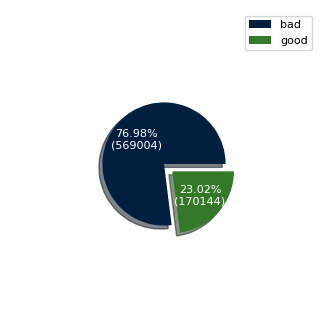

In [13]:
dist_label = {i:0 for i in dataframe.target.unique()}
for val in dataframe.target:
  dist_label[val] += 1

def fmt(x, total):
    return '{:.2f}%\n({:.0f})'.format(x, total*x/100)

colors = ['#001F3F', '#347928']

plt.figure(figsize=(4, 4))
plt.pie(
    dist_label.values(), labels=dist_label.keys(), autopct=lambda x: fmt(x, len(dataframe)),
    textprops={'color': 'white', 'fontsize':8}, radius=.5, explode=[.0, .09],
    colors=colors, shadow=True,
)
plt.legend(fontsize=8)
plt.show()

In the following code cell we are going to balance the dataset based on the `target` column value. Our dataset is quite large, we want to take only `10_000` examples for each class label.

In [43]:
MAX_EXAMPLES = 10_000

# Separate the majority and minority classes
majority_class = dataframe[dataframe['target'] == dataframe['target'].value_counts().idxmax()].iloc[:MAX_EXAMPLES]
minority_class = dataframe[dataframe['target'] == dataframe['target'].value_counts().idxmin()].iloc[:MAX_EXAMPLES]

# Downsample majority class to the size of the minority class
majority_downsampled = resample(
    majority_class,
    replace=False,  # without replacement
    n_samples = MAX_EXAMPLES,  # match minority class size
    random_state=SEED  # for reproducibility
)


# Combine downsampled majority and original minority
balanced_df = pd.concat([majority_downsampled, minority_class]).reset_index(drop=True)

balanced_df.head(3)

,ph,iron,nitrate,chloride,lead,zinc,color,turbidity,fluoride,copper,odor,sulfate,conductivity,chlorine,manganese,total dissolved solids,source,water temperature,air temperature,target
0,5.652153,0.000060,4.441775,266.769505,7.753937e-03,0.295394,Faint Yellow,0.000253,0.361134,1.931976,0.703767,231.430887,124.192680,4.688912,0.015039,479.077020,Reservoir,8.233420,59.780424,bad
1,7.200377,0.031129,4.914280,109.639861,2.810000e-05,1.032849,Faint Yellow,0.436787,0.730908,0.134761,0.081632,71.058317,277.596219,2.281286,0.015850,92.139998,Stream,31.077002,45.287964,bad
2,7.452955,0.082663,4.737505,224.370423,1.070000e-15,0.311613,Yellow,0.101999,2.675462,0.419831,1.157133,86.993193,567.664755,4.722377,0.000365,373.526492,Aquifer,37.287566,33.261277,bad


We can check again if the labels are now balanced using a `pie` chat.

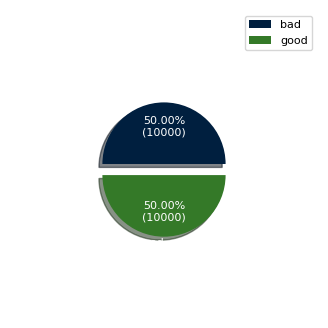

In [44]:
dist_label = {i:0 for i in balanced_df.target.unique()}
for val in balanced_df.target:
  dist_label[val] += 1

def fmt(x, total):
    return '{:.2f}%\n({:.0f})'.format(x, total*x/100)

colors = ['#001F3F', '#347928']

plt.figure(figsize=(4, 4))
plt.pie(
    dist_label.values(), labels=dist_label.keys(), autopct=lambda x: fmt(x, len(balanced_df)),
    textprops={'color': 'white', 'fontsize':8}, radius=.5, explode=[.0, .09],
    colors=colors, shadow=True,
)
plt.legend(fontsize=8)
plt.show()

### Datset Splitting

The next thing that we are going to do is to create 2 subset from our dataframe which are:

1. ``train``
2. ``test``

> The train dataset is going to be used to ``train`` our algorithm and the ``test`` dataset will be used to evaluate the trained model.

For dataset splitting we are going to use the method from `sklearn.model_selection` called `train_test_split`. We are going to take `20%` of the entire dataset and put it to the test set and the remaining data will be left for the training set.


In [45]:
train, test = train_test_split(
    balanced_df, test_size=0.2, random_state=SEED
)

Next we are going to check how the dataset is distributed using a `piechat` accross these two sets.

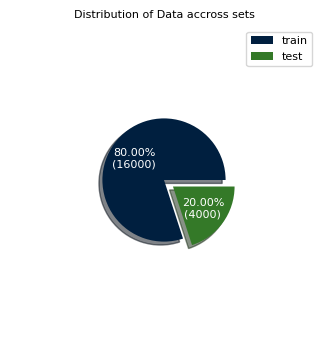

In [46]:
dist_sets = {'train': len(train), 'test': len(test)}

def fmt(x, total):
    return '{:.2f}%\n({:.0f})'.format(x, total*x/100)

colors = ['#001F3F', '#347928']

plt.figure(figsize=(4, 4))
plt.title("Distribution of Data accross sets", fontsize=8)
plt.pie(
    dist_sets.values(), labels=dist_sets.keys(), autopct=lambda x: fmt(x, len(balanced_df)),
    textprops={'color': 'white', 'fontsize':8}, radius=.5, explode=[.0, .09],
    colors=colors, shadow=True,
)
plt.legend(fontsize=8)
plt.show()

We can see that out of all the data in the dataset, `20%` belongs to the testing data and `80%` belongs to the training data. Now that we have split our data what's next??




### Extract features and labels.
Next we are going to get the train features and labels as well as the test features and labels. Our labels are `text` but our features are numbers but some of the features are `text` as well such as [color, source]. However, machine learning algorithims understand numbers. We need a way of converting these labels into numbers. There are many ways of doing this but in this case i will use the simple one. First i will use the get my labels and use the `LabelEncoder` to change these labels to numbers.


> 🤔 Remember, our features are all the columns expect the `target` in the dataframe.

In [47]:
train_features = train.drop(["target"],axis=1).reset_index(drop=True)
train_labels = train["target"].values

test_features = test.drop(["target"],axis=1).reset_index(drop=True)
test_labels = test["target"].values

In [48]:
train.shape, test.shape

((16000, 20), (4000, 20))

In [49]:
train_labels

array(['bad', 'good', 'bad', ..., 'bad', 'good', 'good'], dtype=object)

In [50]:
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.transform(test_labels)
train_labels[:2]

array([0, 1])

In [51]:
label_encoder.inverse_transform(train_labels[:2])

array(['bad', 'good'], dtype=object)

In [52]:
label_encoder.classes_

array(['bad', 'good'], dtype=object)

Next let's get the features that are categorical and features that are numerical.

In [53]:
categorical_columns = np.array(['source', 'color'])
numerical_columns = np.array([i for i in train_features.columns if i not in categorical_columns])

Our labels has been endoded or they are now numerical. What's next??


### Scaling Features.


Our feature are number, however they need to be scaled. So we are going to create a pipeline that will work on tranforming our data in the way that we want. We are going to use something called `ColumnTransformer` from sklearn. We are going to encode each column surperately and scale the features in a pipeline. Here are the transformations that we are going to make for our features.

1. For all the numerical column features we are going to use the `StandardScaler`
2. For all the categorical features we are going to use the `OrdinalEncoder` and then apply `StandardScaler` after they have been encoded to numbers.


### Refs
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
- https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html
- https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.OrdinalEncoder.html


In [54]:
scale_pipeline = Pipeline([
  ('standard_scaler', StandardScaler())
])
enode_and_scale_pipeline = Pipeline([
  ('odinal_scaler', OrdinalEncoder()),
  ('standard_scaler', StandardScaler())
])
ct = ColumnTransformer([
    ("numerical-columns", scale_pipeline,  numerical_columns),
    ("categorical-columns", enode_and_scale_pipeline, categorical_columns),
])
train_features_transformed = ct.fit_transform(train_features)
# on the test data we are only going to transform it
test_features_transformed = ct.transform(test_features)

In [55]:
train_features_transformed[0]

array([-0.38821683, -0.28316006, -0.66065283, -0.53158645, -0.05374448,
        1.04747327, -0.44454347,  0.15495564,  0.58966236,  1.11842688,
       -0.7942842 ,  0.37965028,  0.33553724, -0.27422099, -1.16256387,
        0.05734003, -0.12761178, -0.22030997, -1.26029168])

In [56]:
test_features_transformed[0].shape

(19,)

### Feature Importance

Next we are going to use the `XGBoost` algorithim to learn feature importance based on the data that we have.

In [57]:
xgb_model = xgb.XGBRegressor(
    base_score=0.5,
    booster='gbtree',
    n_estimators=1000,
    early_stopping_rounds=50,
    objective='reg:linear',
    max_depth=3,
    learning_rate=0.01
)

xgb_model.fit(
    train_features_transformed, train_labels,
    eval_set=[(train_features_transformed, train_labels), (test_features_transformed, test_labels)],
    verbose=100
)

[0]	validation_0-rmse:0.49848	validation_1-rmse:0.49849
[100]	validation_0-rmse:0.40786	validation_1-rmse:0.40784
[200]	validation_0-rmse:0.36702	validation_1-rmse:0.36730
[300]	validation_0-rmse:0.34646	validation_1-rmse:0.34682
[400]	validation_0-rmse:0.33495	validation_1-rmse:0.33563
[500]	validation_0-rmse:0.32841	validation_1-rmse:0.32959
[600]	validation_0-rmse:0.32450	validation_1-rmse:0.32629
[700]	validation_0-rmse:0.32198	validation_1-rmse:0.32446
[800]	validation_0-rmse:0.32013	validation_1-rmse:0.32348
[900]	validation_0-rmse:0.31863	validation_1-rmse:0.32283
[999]	validation_0-rmse:0.31748	validation_1-rmse:0.32255


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

Again just like what we did in the previous notebook we are going to visualize these features manually and see which are important and the threshhold that we will take.

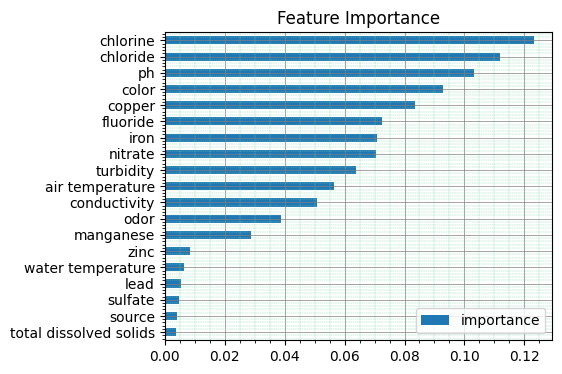

In [58]:
fi = pd.DataFrame(
    data=xgb_model.feature_importances_,
    index=train_features.columns,
    columns=['importance']
)
fi.sort_values('importance').plot(kind='barh', title='Feature Importance', figsize=(5, 4))
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

We can see that they are only few features that are important to detemine water quality which are based on a threshhold of `6%` which are:

```py
['ph', 'iron', 'nitrate', 'chloride', 'color', 'turbidity', 'fluoride', 'copper', 'conductivity', 'chlorine', ]
```

Next we are going to extract those features from our dataframe.

In [59]:
new_features = ['ph', 'iron', 'nitrate', 'chloride', 'color',
       'turbidity', 'fluoride', 'copper', 'conductivity',
       'chlorine',
       ]
train_features = train_features[new_features]
test_features = test_features[new_features]

train_features.head(2)

,ph,iron,nitrate,chloride,color,turbidity,fluoride,copper,conductivity,chlorine
0,7.040606,0.005937,4.082206,150.536866,Colorless,0.146691,1.164478,0.972573,497.969716,3.559920
1,7.427446,0.000064,1.097882,71.736156,Faint Yellow,0.352379,0.333623,0.325360,386.600996,3.279375


Now the only categorical feature that we are left with is `color`. In the next code cell we are going to encode and scale our features.

In [60]:
categorical_columns = ['color']
numerical_columns = [i for i in train_features.columns if i not in categorical_columns]
scale_pipeline = Pipeline([
  ('standard_scaler', StandardScaler())
])
enode_and_scale_pipeline = Pipeline([
  ('odinal_scaler', OrdinalEncoder()),
  ('standard_scaler', StandardScaler())
])
ct = ColumnTransformer([
    ("numerical-columns", scale_pipeline,  numerical_columns),
    ("categorical-columns", enode_and_scale_pipeline, categorical_columns),
])
train_features_transformed = ct.fit_transform(train_features)
test_features_transformed = ct.transform(test_features)

train_features_transformed.shape, test_features_transformed.shape

((16000, 10), (4000, 10))

In [61]:
train_features_transformed[0]

array([-0.38821683, -0.28316006, -0.66065283, -0.53158645, -0.44454347,
        0.15495564,  0.58966236,  0.37965028,  0.33553724, -1.26029168])

### Dimesionality Reduction
In the following code cell we are going to reduce the deminsions of our feature using `PCA`. We are going to make to reduce our features to be `3` and we will plot them using `3D` plot.


In [62]:
pca = PCA(n_components=3)
pca.fit(train_features_transformed)
pca_ds = pd.DataFrame(pca.transform(train_features_transformed), columns=(["feature_1","feature_2", "feature_3"]))
pca_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
feature_1,16000.0,-1.065814e-17,1.160021,-2.727890,-0.822166,-0.229001,0.605974,8.046651
feature_2,16000.0,2.220446e-19,1.004904,-3.964881,-0.688474,-0.075201,0.614751,5.634153
feature_3,16000.0,-3.552714e-18,0.999117,-4.783580,-0.635634,-0.022495,0.604983,5.333244


We can see that now we have `3` features insteard of `10` that we had before. Next we are going to transform our train_features and test_features which are scaled and reduce the dimensionality using `PCA`

In [63]:
pca_train_features_transformed = pca.transform(train_features_transformed)
pca_test_features_transformed = pca.transform(test_features_transformed)
pca_train_features_transformed.shape, pca_test_features_transformed.shape

((16000, 3), (4000, 3))

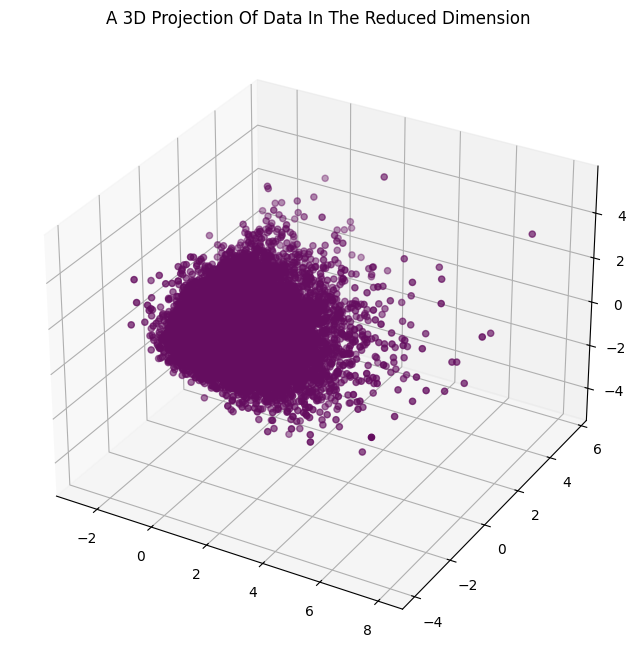

In [64]:
#A 3D Projection Of Data In The Reduced Dimension
x = pca_ds["feature_1"]
y = pca_ds["feature_2"]
z = pca_ds["feature_3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x, y ,z, c="#640D5F", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

### Model Selection

In this section we are going to search amoung all the classification algorithim to see which one will perform better for our task. The classification algorithms that we are going to try which are:

1. `LogisticRegression`
2. `DecisionTreeClassifier`
3. `RandomForestClassifier`
4. `SVC`
5. `KNN`

### Refs
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
- https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [65]:
train_labels_transformed = train_labels
test_labels_transformed = test_labels

pipeline_lr = Pipeline([('lr_classifier', LogisticRegression(random_state=SEED, max_iter=100))])
pipeline_dt = Pipeline([ ('dt_classifier', DecisionTreeClassifier(random_state=SEED))])
pipeline_rf = Pipeline([('rf_classifier', RandomForestClassifier())])
pipeline_svc = Pipeline([('sv_classifier', SVC())])
pipeline_knn = Pipeline([('knn_classifier', KNeighborsClassifier(n_neighbors=5))])

pipelines = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_svc, pipeline_knn]
pipe_dict = {0: 'Logistic Regression', 1: 'Decision Tree', 2: 'RandomForest', 3: "SVC", 4: 'KNN'}

for pipe in pipelines:
    pipe.fit(pca_train_features_transformed, train_labels_transformed)

Next we are going to calculate the `cross_validation_score` among our classification models and see which classification algorithm does perform better based on our data.

In [66]:
cv_results_accuracy = []
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, pca_test_features_transformed, test_labels_transformed, cv=10 )
    cv_results_accuracy.append(cv_score)
    print("%s: %f \t" % (pipe_dict[i], cv_score.mean()))

Logistic Regression: 0.730750 	
Decision Tree: 0.667750 	
RandomForest: 0.770500 	
SVC: 0.783000 	
KNN: 0.754750 	


We can see among all the algorithms, the `SVC` has better cross validation score than the others. We are going to use that to build our model that we will evaluate. But before we do that we want to use the `GridSearchCV` to find the best parameters that we can pass to our `SVC` classifier.

### Refs

- https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html
- https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [67]:

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10], 'gamma': ['scale', 'auto'] }
classifier = SVC()
gs = GridSearchCV(classifier, parameters)
gs.fit(pca_train_features_transformed, train_labels_transformed)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ('linear', 'rbf')})

In [68]:
gs.best_params_

{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}

In [69]:
model = SVC(**gs.best_params_)
model.fit(pca_train_features_transformed, train_labels_transformed)

SVC(C=10, gamma='auto')

### Model Scores.

In [70]:
model.score(pca_train_features_transformed, train_labels_transformed)

0.791125

In [71]:
model.score(pca_test_features_transformed, test_labels_transformed)

0.77975

### Classifier Performance
In this section we are going to have a look on how well our classifier model will be performing interms of the following metrics.

1. Confusion Matrix
2. Precision
3. Recall
4. F1 Score

### F1 Score
F1 score is a machine learning evaluation metric that measures a model's accuracy. It combines the precision and recall scores of a model. The accuracy metric computes how many times a model made a correct prediction across the entire dataset.


First let's make predictions for all our 2 sets, train and test.

In [72]:
# predicted labels
train_preds = model.predict(pca_train_features_transformed)
test_preds = model.predict(pca_test_features_transformed)

# real labels
y_train = train_labels_transformed
y_test = test_labels_transformed

We can check the first 10 predicted labels as follows.

In [73]:
train_preds[:10]

array([0, 0, 0, 1, 1, 0, 0, 1, 1, 0])

In [74]:
y_train[:10]

array([0, 1, 0, 1, 1, 1, 0, 1, 1, 1])

Now we can calculate the ``f1_scores`` for each label in from the train set as follows:

In [75]:
classes = label_encoder.classes_
train_score = f1_score(y_train, train_preds, labels=np.array([0, 1]), average=None)
test_score = f1_score(y_test, test_preds, labels=np.array([0, 1]), average=None)

print("Train F1-Score: \t", list(zip(train_score, classes)))
print("Test F1-Score: \t", list(zip(test_score, classes)))

Train F1-Score: 	 [(0.7983832046332047, 'bad'), (0.7833246887966805, 'good')]
Test F1-Score: 	 [(0.7806821010704506, 'bad'), (0.778809942254582, 'good')]


### Precision Score
Precision score measures the proportion of positively predicted labels that are actually correct. Precision is also known as the positive predictive value. Let's check the precision score of our model based on our examples in each set.

In the train set the precision score are as follows:

In [76]:
train_score = precision_score(y_train, train_preds, labels=np.array([0, 1]), average=None)
test_score = precision_score(y_test, test_preds, labels=np.array([0, 1]), average=None)

print("Train Precision: \t", list(zip(train_score, classes)))
print("Test Precision: \t", list(zip(test_score, classes)))

Train Precision: 	 [(0.7785621837863278, 'bad'), (0.8053592854286096, 'good')]
Test Precision: 	 [(0.7488061127029608, 'bad'), (0.8137460650577125, 'good')]


### Recall Score

Recall is the true positive rate, also referred to as sensitivity, which measures the probability of ground truth objects being correctly detected. Similarly, Recall ranges from 0 to 1, where a high recall score means that most ground truth objects were detected.

In [77]:
train_score = recall_score(y_train, train_preds, labels=np.array([0, 1]), average=None)
test_score = recall_score(y_test, test_preds, labels=np.array([0, 1]), average=None)

print("Train Precision: \t", list(zip(train_score, classes)))
print("Test Precision: \t", list(zip(test_score, classes)))

Train Precision: 	 [(0.8192398167636499, 'bad'), (0.7624637132399343, 'good')]
Test Precision: 	 [(0.8153926157046282, 'bad'), (0.7467501203659124, 'good')]


### Accuracy Score
Though this is not a good measure of how our model is performing when unbalanced examples for each label. However in our dataset our examples have labels that are close to balanced and we can use this metric to measure the model performance. The accuracy score can be caluculated as follows:



In [78]:
train_accuracy = accuracy_score(y_train, train_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print("Train Acc: \t", train_accuracy)
print("Test Acc: \t", test_accuracy)

Train Acc: 	 0.791125
Test Acc: 	 0.77975


### Classification Report.

The classification report visualizer displays the `precision`, `recall`, `F1`, and support scores for the model. Let's display the classification report for each set.

Let's print the classification report based on the train predictions.

In [79]:
train_preds

array([0, 0, 0, ..., 0, 1, 1])

In [80]:
cr = classification_report(y_train, train_preds, output_dict=False, target_names = classes)
print(cr)

              precision    recall  f1-score   support

         bad       0.78      0.82      0.80      8077
        good       0.81      0.76      0.78      7923

    accuracy                           0.79     16000
   macro avg       0.79      0.79      0.79     16000
weighted avg       0.79      0.79      0.79     16000



In [81]:
cr = classification_report(y_test, test_preds, output_dict=False, target_names = classes)
print(cr)

              precision    recall  f1-score   support

         bad       0.75      0.82      0.78      1923
        good       0.81      0.75      0.78      2077

    accuracy                           0.78      4000
   macro avg       0.78      0.78      0.78      4000
weighted avg       0.78      0.78      0.78      4000



### Confusion Matrix
Next we are going to plot the confusion matrix and visually see how well our model is performing in predicting load shedding impact given some features and how confused it is between these different classes.

In [82]:
cm = confusion_matrix(y_train, train_preds)
print(cm)

[[6617 1460]
 [1882 6041]]


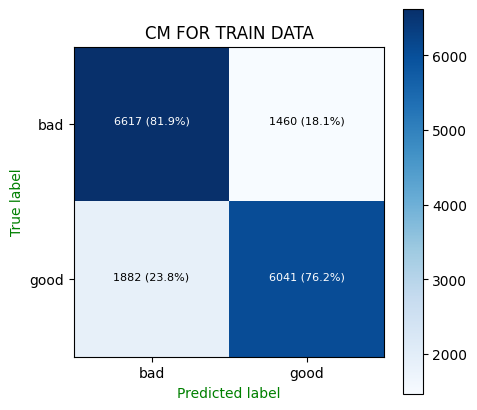

In [83]:
plot_complicated_confusion_matrix(y_train, train_preds,
  classes, fontsize=8, figsize=(5, 5), title="CM FOR TRAIN DATA"
)

In [84]:
cm = confusion_matrix(y_test, test_preds)
print(cm)

[[1568  355]
 [ 526 1551]]


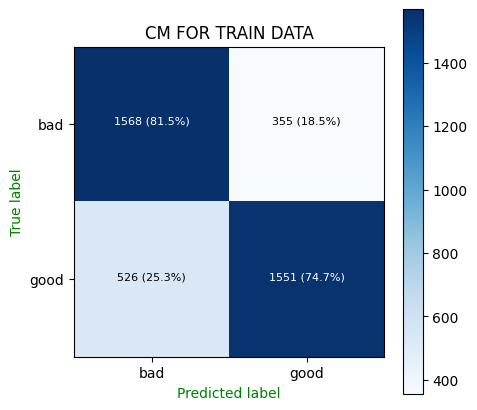

In [85]:
plot_complicated_confusion_matrix(y_test, test_preds,
  classes, fontsize=8, figsize=(5, 5), title="CM FOR TRAIN DATA"
)

### Model Inference.

In this section we are going to make some predictions using our model.

Next we are going to use `Deep Leaning` to perform the same task.